# Calculate Shortest Path and Generate OD Matrx
This notebook 
* attribute farms and potential digester locations to road network nodes
* calculate all-pair shortest paths between farms and all potential digester locations
* save the OD matrix (C_ij) as dictionary {p0: {f0: distance, f1: distance}...}

In [2]:
from cflp_function import store_data_to_pickle
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import h3
from shapely.ops import nearest_points
from shapely.geometry import Polygon, Point
from fiona.crs import from_epsg

In [3]:
%matplotlib inline

In [4]:
loi = pd.read_csv('./hex/loi.csv')

In [5]:
# Define a function to convert H3 index to Shapely polygon and center coordinates
def cell_to_shapely_polygon(h3_index):
    # hex_center_coords = h3.h3_to_geo(h3_index)
    coords = h3.h3_to_geo_boundary(h3_index)
    flipped = tuple(coord[::-1] for coord in coords)
    # center_point = Point(hex_center_coords)
    return Polygon(flipped) #, center_point

In [6]:
def cell_to_shaply_point(h3_index):
    lat, lon = h3.h3_to_geo(h3_index)
    return Point(lon, lat)

In [7]:
# loi[['polygon', 'center_coords']] = loi['hex9'].apply(h3_to_polygon_and_center).apply(pd.Series)
loi['polygon'] = loi['hex9'].apply(lambda x: cell_to_shapely_polygon(x)) 

In [8]:
loi['geometry'] = loi['hex9'].apply(cell_to_shaply_point)

In [9]:
# Convert 'polygon' and 'center_coords' columns to GeoDataFrame
loi_gdf = gpd.GeoDataFrame(loi, geometry='geometry', crs=4326)

# Optional: If you also want to include the center coordinates as a separate geometry column
# loi_gdf['center_point'] = loi['center_coords']

In [10]:
main_crs ='EPSG:4326'

## 1. Farms to Nodes (QGIS)
Inputs:
* n - road network nodes (GeoDataFrame)
* farm - farm location points (GeoDataFrame)
* polygon_gdf - potential digester location polygons (GeoDataFrame)

In [11]:
n = gpd.read_file(r"./osm_network/G_n.shp")
n.head()

,osmid,y,x,lon,lat,highway,geometry
0,0,6.863327e+06,732329.118328,6.578624,52.348177,None,POINT (732329.118 6863326.894)
1,1,6.862993e+06,732029.301544,6.575931,52.346343,None,POINT (732029.302 6862992.539)
2,2,6.863769e+06,732826.404757,NaN,NaN,None,POINT (732826.405 6863768.536)
3,3,6.863381e+06,733531.413357,6.589425,52.348473,None,POINT (733531.413 6863380.689)
4,4,6.865492e+06,731879.617087,NaN,NaN,None,POINT (731879.617 6865492.254)


In [12]:
farm = gpd.read_file("./farm/farm_new.shp")

In [13]:
print(n.crs, farm.crs)

EPSG:3857 EPSG:4326


In [14]:
n = n.to_crs(main_crs)
# farm = farm.to_crs('EPSG:28992')

In [15]:
# polygon_gdf = gpd.read_file("./raster/suitable_polygons_complete_gdf.shp")
# polygon_gdf.head()

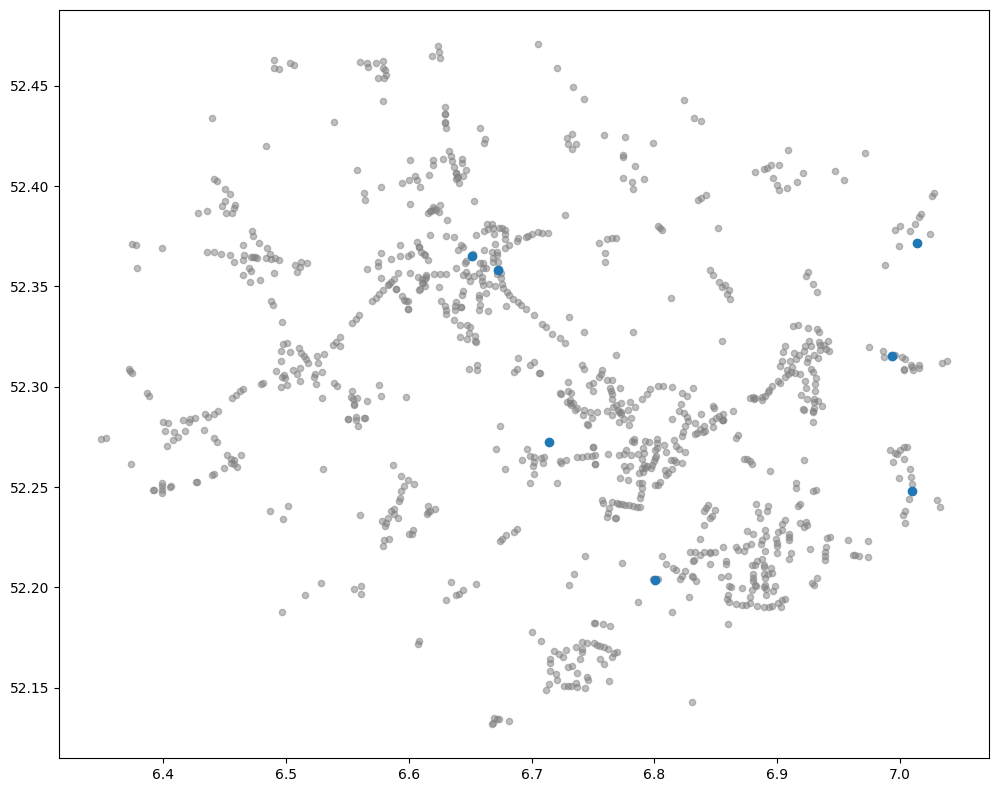

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
# farm.plot(ax=ax, markersize=20, marker='^', color='red', alpha = 0.6)
n.plot(ax=ax, markersize=20, color='grey', alpha=0.5)
loi_gdf.plot(ax=ax)
# for x, y, idx in zip(farm.geometry.x, farm.geometry.y, farm.index.values):
#     ax.annotate(idx, (x, y), textcoords='offset points', xytext=(0,5), ha='center')
# Annotate the points with their 'osmid' values
# for x, y, osmid in zip(n.geometry.x, n.geometry.y, n['osmid']):
#     ax.annotate(osmid, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
# for x, y, l in zip(loi_gdf.centroid.x, loi_gdf.centroid.y, loi_gdf.index.values):
#     ax.annotate(l, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.show()

In [17]:
def find_closest_osmid(gdf, n):
    gdf['closest_osmid'] = gdf['geometry'].apply(
        lambda location: n.loc[n['geometry'] == nearest_points(location, n.unary_union)[1], 'osmid'].iloc[0])

In [32]:
find_closest_osmid(farm, n)

In [19]:
find_closest_osmid(loi_gdf, n)

In [20]:
# # Find the nearest node for each farm
# farm['closest_osmid'] = farm['geometry'].apply(
#     lambda location: n.loc[n['geometry'] == nearest_points(location, n.unary_union)[1], 'osmid'].iloc[0]
# )

In [21]:
# polygon_gdf['centroid'] = polygon_gdf['geometry'].centroid

In [22]:
# # Find the nearest node in n for each centroid
# polygon_gdf['closest_osmid'] = polygon_gdf['centroid'].apply(
#     lambda centroid: n.loc[n['geometry'] == nearest_points(centroid, n.unary_union)[1], 'osmid'].iloc[0]
#     # lambda centroid: n.loc[nearest_points(centroid, n.unary_union)[1].x, 'osmid']
# )

## Plant for test

In [23]:
# potential_plant_location = pd.read_csv('./farm_cluster_mock_5.csv')
# potential_plant_location.head()

In [24]:
# nearest_neighbor = pd.read_csv('./osm_network/nearest_neighbor.csv')
# nearest_neighbor.head()

Here I should be loading set P from another file, I meant the file that has the indices of nodes representing the potential digester location

In [25]:
# nearest_neighbor_p = pd.read_csv('./osm_network/nearest_neighbor_p.csv')
# nearest_neighbor_p.head()

In [26]:
# nearest_neighbor = nearest_neighbor.rename(columns={"TargetID": "osmid"})

In [27]:
# merged_df = pd.merge(farm, nearest_neighbor, how='left', left_on="IND_OBJ_NA", right_on='InputID')
# merged_df.head()

In [28]:
# potential_plant_location['osmid'] = nearest_neighbor_p['TargetID']

## 2. Calculate OD Matrix
Inputs:
* Road network with farm information at nodes 
* Set of potential digester locations 

In [29]:
g = ox.load_graphml('./osm_network/G.graphml') 

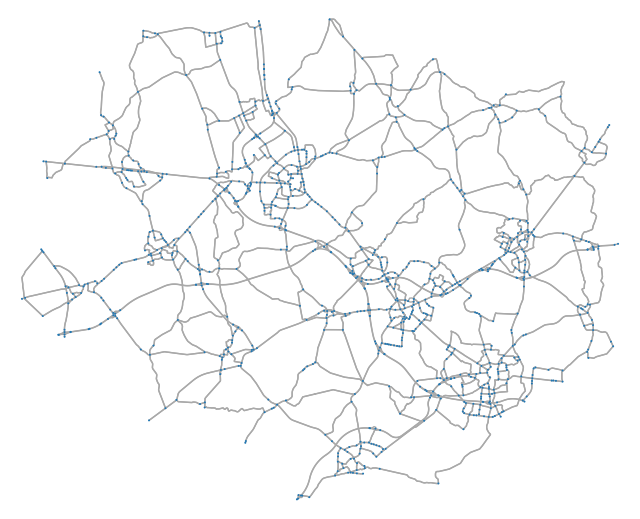

In [20]:
fig, ax = ox.plot_graph(g, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')

In [30]:
orig = farm['closest_osmid'].unique().tolist()
print(orig)

[528, 845, 655, 855, 195, 226, 81, 643, 888, 739, 249, 105, 144, 96, 222, 92, 67, 787, 165, 321, 615, 354, 340, 98, 257, 383, 630, 727, 564, 578, 84, 93, 347, 170, 486, 117, 333, 54, 150, 11, 874, 597, 208, 94, 338, 570, 241, 410, 701, 614, 745, 654, 679, 673, 741, 732, 502, 771, 814, 9, 263, 229, 76, 286, 210, 942, 64, 17, 23, 16, 203, 319, 100, 198, 459, 824, 791, 815, 725, 764, 959, 961, 828, 861, 599, 457, 164, 836, 310, 318, 682, 698, 50, 998, 331, 413, 442, 474, 290, 213, 473, 505]


In [33]:
dest = loi_gdf['closest_osmid'].unique().tolist()
print(dest)

[564, 770, 242, 319, 105, 682, 701]


In [79]:
# # Plant for test
# dest = potential_plant_location['osmid'].unique().tolist()

In [80]:
# dest = polygon_gdf['closest_osmid'].unique().tolist()
# print(dest)

In [34]:
# Initialize an empty OD matrix
od_matrix = {}

In [35]:
# Calculate shortest path between all pair orig (farm) and dest (potential location)
for origin in orig:
    od_matrix[origin] = {}
    for destination in dest:
        distance = nx.shortest_path_length(g, origin, destination, weight='length')
        od_matrix[origin][destination] = distance/1000 # convert from m to km
# {orig:{dest:distance, dest:distance....}}

In [36]:
# Initialize an empty nested dictionary
new_nested_dict = {}

# Create a new nested dictionary with DataFrame index as keys
for idx, row in farm.iterrows():
    osmid_value = row['closest_osmid']
    if osmid_value in od_matrix:
        new_nested_dict[idx] = od_matrix[osmid_value]

# {farm1:{dest:distance, dest:distance....}} # some nodes are the closest for more than 1 farms, so now we make sure the dictionary is with key of all farms and each take the 
# associated distances (i.e. some farms will have the same od to all dest)

In [37]:
for key, value in new_nested_dict.items():
    print(f"{key}:{value}")

0:{564: 30.25995505737501, 770: 32.044457419732915, 242: 35.898505614452354, 319: 14.97304480043357, 105: 23.89540808553838, 682: 14.152933805968893, 701: 17.844713215322596}
1:{564: 34.033553137793305, 770: 22.87298478096802, 242: 42.592552656343265, 319: 40.68345750486417, 105: 47.12294504408197, 682: 25.601797696869443, 701: 26.354678524902482}
2:{564: 22.661734745368864, 770: 23.881685752152503, 242: 31.220734263918814, 319: 29.31163911243972, 105: 35.75112665165752, 682: 25.680421824150883, 701: 26.433302652183922}
3:{564: 37.20369550329262, 770: 33.00799657596771, 242: 45.762695021842575, 319: 36.08826906460893, 105: 47.21177416740885, 682: 18.611773161655066, 701: 19.364653989688108}
4:{564: 54.74687558979437, 770: 62.696559495762145, 242: 57.126689622227, 319: 22.083642585206817, 105: 36.96810052773982, 682: 37.56943571663287, 701: 36.25426700222314}
5:{564: 51.93588457629426, 770: 59.88556848226203, 242: 54.31569860872689, 319: 19.27265157170671, 105: 34.311475520098, 682: 31.

In [38]:
placeholders = {i:j for i, j in zip(loi_gdf.index.values, loi_gdf['closest_osmid'])}

In [39]:
restructured_od = {}

for farm, distances in new_nested_dict.items():
    restructured_od[farm] = {}
    for index, placeholder in placeholders.items():
        restructured_od[farm][index] = distances.get(placeholder, None)

transport_cost = {(farm, index): distance for farm, distances in restructured_od.items() for index, distance in distances.items()}

In [108]:
# # Transform the nested dictionary such that the OD matrix is a dictionary with dest as main keys {dest1{farm1:distance, farm2:distance.....}}
# transportation_cost = {}
# for outer_key, inner_dict in new_nested_dict.items():
#     for inner_key, value in inner_dict.items():
#         if inner_key not in transportation_cost:
#             transportation_cost[inner_key] = {outer_key: value}
#         else:
#             transportation_cost[inner_key][outer_key] = value

In [109]:
# for key, value in transportation_cost.items():
#     print(f"{key}: {value}")

In [110]:
# For TEST - Switch key of OD matrix from osmid to numbers 
# transportation_cost = {i: transportation_cost[key] for i, key in enumerate(transportation_cost)}

In [44]:
# For actual model run - Switch key of OD matrix from osmid to Label of plant
# transportation_cost = {l: transportation_cost[osmid] for l, osmid in zip(polygon_gdf['Label'], polygon_gdf['closest_osmid'])}

In [40]:
cost_per_km = 0.69

# Function to multiply values in nested dictionary by 0.69
# def multiply_dict_values(d, cost_per_km=cost_per_km):
#     for k, v in d.items():
#         if isinstance(v, dict):
#             multiply_dict_values(v)
#         else:
#             d[k] = v * cost_per_km
# Multiply the values by 0.69
transport_cost = {key: value * cost_per_km for key, value in transport_cost.items()}

In [41]:
for key, value in transport_cost.items():
    print(f"{key}: {value}")

(0, 0): 20.879368989588755
(0, 1): 22.11067561961571
(0, 2): 24.76996887397212
(0, 3): 10.331400912299163
(0, 4): 16.48783157902148
(0, 5): 9.765524326118536
(0, 6): 12.31285211857259
(1, 0): 23.48315166507738
(1, 1): 15.782359498867933
(1, 2): 29.38886133287685
(1, 3): 28.07158567835628
(1, 4): 32.51483208041656
(1, 5): 17.665240410839914
(1, 6): 18.18472818218271
(2, 0): 15.636596974304515
(2, 1): 16.478363168985226
(2, 2): 21.54230664210398
(2, 3): 20.225030987583406
(2, 4): 24.668277389643688
(2, 5): 17.719491058664108
(2, 6): 18.238978830006904
(3, 0): 25.670549897271908
(3, 1): 22.775517637417718
(3, 2): 31.576259565071375
(3, 3): 24.90090565458016
(3, 4): 32.5761241755121
(3, 5): 12.842123481541995
(3, 6): 13.361611252884794
(4, 0): 37.77534415695811
(4, 1): 43.26062605207588
(4, 2): 39.41741583933663
(4, 3): 15.237713383792704
(4, 4): 25.507989364140474
(4, 5): 25.922910644476676
(4, 6): 25.015444231533962
(5, 0): 35.83576035764303
(5, 1): 41.3210422527608
(5, 2): 37.4778320400

In [113]:
# Multiply all values in the nested dictionary by 0.69
# multiply_dict_values(transportation_cost)

In [114]:
# # Print the new nested dictionary
# print("New Nested Dictionary:")
# for key, value in transportation_cost.items():
#     print(f"{key}: {value}")

In [49]:
store_data_to_pickle(transport_cost, 'app_data', 'c_test.pickle')
store_data_to_pickle(loi_gdf.index.tolist(), 'app_data', 'Plant_test_2.pickle')